# Online prediction for radon-medium

In online mode, the model is learning as soon as a new data arrives.
It means that when we want our prediction we don't need to provide feature vector, 
since all data was already processed by the model.

Explore the following models:

  * DailyPattern - Calculate daily pattern from historical data. Use it as next day prediction. Use all days
  * Explore flow - rainfall correlation
  * RainfallModel - Model which uses rainfall data (with forecast)

In [1]:
import datetime
import calendar
import json
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

# Load project

In [2]:
project_folder = '../../datasets/radon-medium/'
with open(project_folder + 'project.json', 'r') as file:
    project = json.load(file)
print('Project info:')
print('  Name      : {:}'.format(project['name']))
print('  Start date: {:}'.format(project['start-date']))
print('  Split date: {:}'.format(project['split-date']))
print('  End date  : {:}'.format(project['end-date']))
print('')

print('Flow1')
flow = pd.read_csv(project_folder + 'flow1.csv', parse_dates=['time'])
flow = flow.set_index('time')['flow'].fillna(0)
flow = flow.resample('5T').pad()
flow = flow[project['start-date']: project['end-date']]
print(flow.head())
print('')

print('Rainfall1')
rainfall = pd.read_csv(project_folder + 'rainfall1.csv', parse_dates=['time'])
rainfall = rainfall.set_index('time')['rainfall'].fillna(0)
rainfall = rainfall.resample('5T').pad()
rainfall = rainfall[project['start-date']: project['end-date']]
print(rainfall.head())

Project info:
  Name      : radon-medium
  Start date: 2014-11-01
  Split date: 2016-11-01
  End date  : 2017-11-01

Flow1
time
2014-11-01 00:00:00    87.804360
2014-11-01 00:05:00    87.682940
2014-11-01 00:10:00    88.550255
2014-11-01 00:15:00    89.575424
2014-11-01 00:20:00    89.338270
Freq: 5T, Name: flow, dtype: float64

Rainfall1
time
2014-11-01 00:00:00    0.2
2014-11-01 00:05:00    0.0
2014-11-01 00:10:00    0.0
2014-11-01 00:15:00    0.4
2014-11-01 00:20:00    0.0
Freq: 5T, Name: rainfall, dtype: float64


## Helper functions

Helper functions for building training and test sets and calculating score

In [3]:
class PredictionModel:
    
    def fit(self, fs, rs):
        pass
        
    def predict(self, forecast):
        pass

    
def mae(y_hat, y):
    """
    Calculate Mean Absolute Error 
    This metric is better here since serries have quite big outliers
    """
    return np.sum(np.absolute(y_hat-y))/y.shape[0]


def split_data(split_day):
    """Get all data up to a given day"""
    end_day = split_day - pd.Timedelta('1 min')
    return flow[:end_day], rainfall[:end_day]


def evaluate_day(model, split_day):
    """Evaluate data for single day"""
    fs, rs = split_data(split_day)
    next_day = split_day + pd.Timedelta(1, 'D')
    forecast = rainfall[next_day: next_day+pd.Timedelta('1439 min')]
    y = flow[next_day: next_day+pd.Timedelta('1439 min')]
    model.fit(xs)
    y_hat = model.predict(next_day, forecast)
    return mae(y_hat, y)


def evaluate_model(model, start_day):
    """
    Evaluate model on all days starting from split_day.
    Returns 90th percentile error as model score
    """
    last_day = pd.Timestamp(project['end-date'])
    split_day = start_day
    costs = []
    while split_day < last_day:
        cost = evaluate_day(model, split_day)
        costs.append(cost)
        split_day += pd.Timedelta(1, 'D')
    return np.percentile(costs, 90), costs


xs, ys = split_data(pd.Timestamp('2016-11-10'))
print(xs.tail())

time
2016-11-09 23:35:00    77.777820
2016-11-09 23:40:00    77.021540
2016-11-09 23:45:00    76.518930
2016-11-09 23:50:00    76.294914
2016-11-09 23:55:00    74.822395
Freq: 5T, Name: flow, dtype: float64


# Base Model

This model is used as baseline metric. It is the best model which can be used when there is noi information about precipitation.

We expect that later when we include information about rainfall our model we have better (lower) score.

## Daily Pattern model

Create pattern of daily usage based on historical data. Use this pattern to predict next values

(This can take up to 10 minutes to calculate)

In [4]:
class DailyPatternModel(PredictionModel):
    
    def fit(self, xs):
        df = flow.to_frame().reset_index()
        self.daily_pattern = df.groupby(by=[df.time.map(lambda x : (x.hour, x.minute))]).flow.mean().values
        
    def predict(self, day, forecast):
        return self.daily_pattern

    
score, costs = evaluate_model(DailyPatternModel(), pd.Timestamp('2016-11-11'))
print('DailyPatternModel score: {:.2f}'.format(score))

DailyPatternModel score: 9.80


# Explore rainfall - flow correlation

Lets try to find if there is correlation between excessive flow (bigger then daily pattern) and precipitation in the last n hours.

In [18]:
df = flow.to_frame().reset_index()
daily_pattern = df.groupby(by=[df.time.map(lambda x: x.time())]).flow.median()
# Lets join flow and rain into single data frame
df = flow.to_frame().join(rainfall.to_frame()).reset_index()
# Excessive is a flow induced by rain
df['excessive'] = df['flow'] - df['time'].apply(lambda x: daily_pattern[x.time()])
df

def plot_correlation(xs, lag):
    xs['rain_lag'] = xs['rainfall'].rolling(int(lag*12)).sum()
    xs = xs[xs.rain_lag > 10]
    plt.scatter(xs.rain_lag, xs.excessive)
    plt.show()
    m,b = np.polyfit(xs.rain_lag, xs.excessive, 1)
    print('m = {:}, b = {:}'.format(m,b))

### Plot 30 minutes

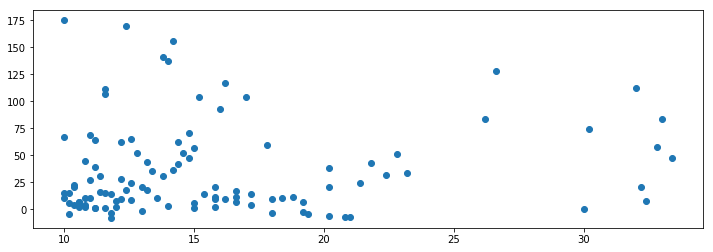

m = 0.8734611074192546, b = 21.022837671672466


In [19]:
plot_correlation(df, 0.5)

### Plot 1h lag

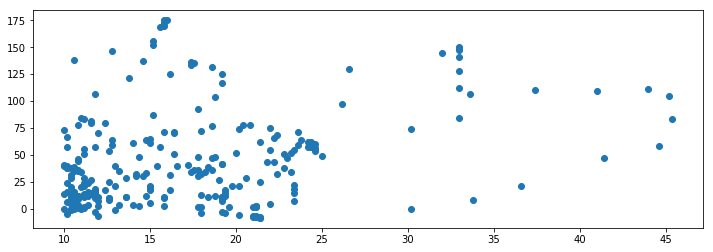

m = 2.0671000882466273, b = 6.609703639255079


In [20]:
plot_correlation(df, 1)

### Plot 2h lag

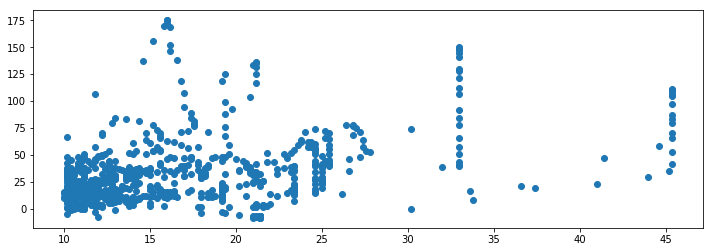

m = 1.750952212511145, b = 1.5490078268756977


In [13]:
plot_correlation(df, 2)

### Plot 4h lag

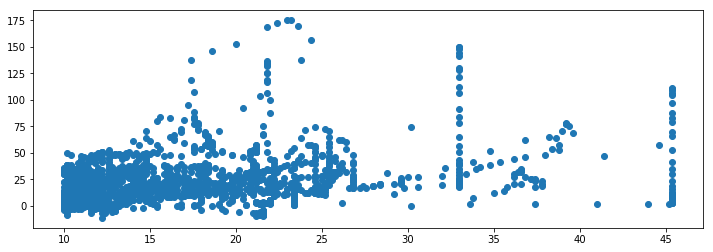

m = 0.8256012833083691, b = 8.42787130084113


In [14]:
plot_correlation(df, 4)

### Plot 8h lag

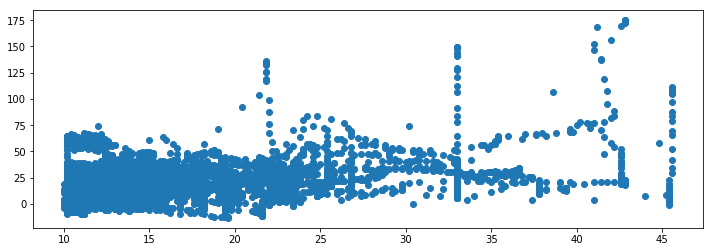

m = 0.5434616878019638, b = 9.527148386823871


In [15]:
plot_correlation(df, 8)